In [1]:
import jax.numpy as np
import matplotlib.pyplot as plt
import numpy as onp

import jax 

from astropy.io import fits

from glob import glob

import halospec.objectives as obj

import jaxopt

from matplotlib.widgets import Slider

jax.config.update("jax_enable_x64", True)

%matplotlib inline


In [2]:
# ls ../data/MAST_2023-02-09T2333/JWST/

In [3]:
# ddir = '../data/MAST_2023-02-09T2331/JWST/' # unsaturated 
ddir = '../data/MAST_2023-02-09T2333/JWST/'# saturated
datasets = glob(ddir+'*')
# print(datasets)

# figure out which targets are which
for j, dataset in enumerate(datasets):
    try:
        ifu = glob(dataset+'/*s3d*')
        hdr = fits.getheader(ifu[0])
        name = hdr['OBSLABEL']
        print(j, name)
    except:
        print(j,'--')

0 Hygiea/MIRI Background
1 Ceres/MIRI
2 Pallas/MIRI
3 Ceres/MIRI
4 Hygiea/MIRI Background
5 Pallas/MIRI Background
6 Hygiea/MIRI Background
7 Ceres/MIRI Background
8 Hygiea/MIRI
9 Ceres/MIRI
10 Pallas/MIRI
11 Hygiea/MIRI
12 Ceres/MIRI Background
13 Pallas/MIRI Background
14 Pallas/MIRI Background
15 Ceres/MIRI Background
16 Hygiea/MIRI
17 Ceres/MIRI
18 Hygiea/MIRI
19 Ceres/MIRI Background
20 Pallas/MIRI
21 Pallas/MIRI
22 Hygiea/MIRI Background
23 Pallas/MIRI Background


In [4]:
# dataset = ddir + 'jw01244-o024_t003_miri_ch4-shortmediumlong/'

index = 1 # Ceres
dataset = datasets[index]+'/'
# print(dataset)

ifu = glob(dataset+'*s3d*')
print('IFU Filename',ifu[0])
# print(files)

extracted = glob(dataset+'*x1d*')
print('Extracted Spectrum filename',extracted[0])
extracted_hdr = fits.getheader(extracted[0],ext=1)

hdu = fits.open(ifu[0])
data = fits.getdata(ifu[0])
hdr = fits.getheader(ifu[0])
name = hdr['OBSLABEL']

extracted = glob(dataset+'*x1d*')
extracted_hdr = fits.getheader(extracted[0],ext=1)
extracted_data = fits.getdata(extracted[0],ext=1)
wavels, ext_spec = extracted_data['WAVELENGTH'], extracted_data['FLUX']
ext_spec /= onp.nanmedian(ext_spec)

print('\nTarget:',name)

IFU Filename ../data/MAST_2023-02-09T2333/JWST/jw01244-o022_t001_miri_ch3-shortmediumlong/jw01244-o022_t001_miri_ch3-shortmediumlong_s3d.fits
Extracted Spectrum filename ../data/MAST_2023-02-09T2333/JWST/jw01244-o022_t001_miri_ch3-shortmediumlong/jw01244-o022_t001_miri_ch3-shortmediumlong_x1d.fits

Target: Ceres/MIRI


# Visualize a slice

Text(0.5, 1.0, 'Zero')

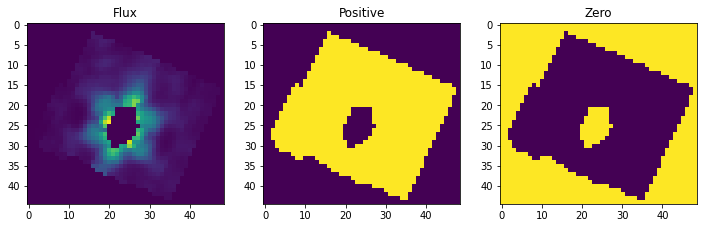

In [5]:
# one frame
fig, (ax1, ax2, ax3) = plt.subplots(1,3,figsize=(12.0,4.0))

ax1.imshow(data[0,:,:])
ax1.set_title('Flux')

ax2.imshow(data[0,:,:]>0)
ax2.set_title('Positive')

ax3.imshow(data[0,:,:]==0)
ax3.set_title('Zero')

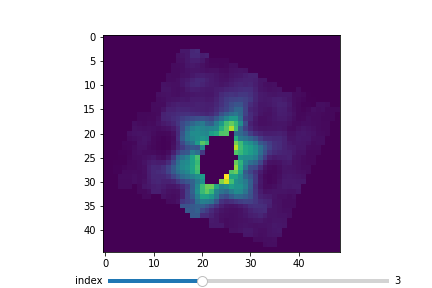

In [6]:
%matplotlib widget 
idx0 = 3
l = plt.imshow(data[idx0])

axidx = plt.axes([0.25, 0.01, 0.65, 0.03])
slidx = Slider(axidx, 'index', 0, 9, valinit=idx0, valfmt='%d')

def update(val):
    idx = slidx.val
    l.set_data(data[int(idx)])
    fig.canvas.draw_idle()
    
slidx.on_changed(update)

plt.show()


Text(0.5, 1.0, 'Zero')

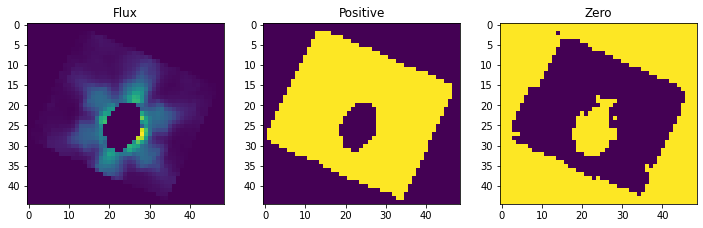

In [7]:
%matplotlib inline

# all frames
fig, (ax1, ax2, ax3) = plt.subplots(1,3,figsize=(12.0,4.0))

ax1.imshow(onp.median(data,axis=0))
ax1.set_title('Flux')

ax2.imshow(onp.median(data,axis=0)>0)
ax2.set_title('Positive')

ax3.imshow(onp.min(data,axis=0)==0)
ax3.set_title('Zero')

So they are using zero-masking. That's good!

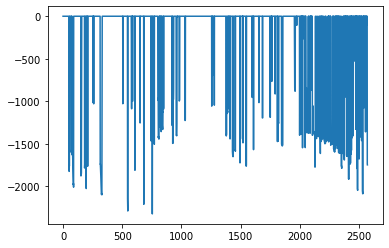

In [8]:
# ravel pixels
ravelled = np.reshape(data,(data.shape[0],data.shape[1]*data.shape[2]))
plt.plot(onp.min(ravelled,axis=1)) # some frames are badly corrected?

In [9]:
# frame rejection
goodframes = onp.min(ravelled,axis=1)==0

# pixel rejection
goodpix = onp.min(data,axis=0)>0

# censored data
newdata = data[:,goodpix]
newdata = newdata[goodframes]

wavels, ext_spec = wavels[goodframes],ext_spec[goodframes]
print('Shape of censored data in spectra x spaxels:',newdata.shape)

Shape of censored data in spectra x spaxels: (2046, 879)


# Plot a random selection of spectra 

Text(0.5, 0, 'Wavelength (μm)')

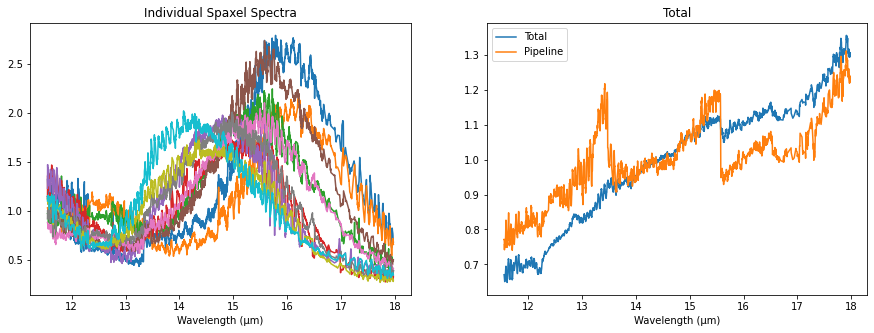

In [10]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(15.0,5.0))
for j in range(10):
    spec = newdata[:,j]
    ax1.plot(wavels,spec/onp.nanmedian(spec))
ax1.set_title('Individual Spaxel Spectra')
ax1.set_xlabel('Wavelength (μm)')
    
flat = onp.sum(newdata,axis=1)
flat /= onp.nanmedian(flat)
ax2.plot(wavels,flat,label='Total')
ax2.plot(wavels,ext_spec,label='Pipeline')
plt.legend()

ax2.set_title('Total')
ax2.set_xlabel('Wavelength (μm)')


# Now let's do a TV-min spectral extraction.

We will compare the classic TV-min algorithm from [White et al, 2017](https://ui.adsabs.harvard.edu/abs/2017MNRAS.471.2882W/abstract) to L2 and standard-deviation-optimization algorithms. 

In [11]:
from jaxopt import LBFGS

In [12]:
def make_spec(weights,spaxels):
    spec = np.dot(obj.softmax(weights),spaxels)
    return spec/np.median(spec)


spaxels = np.array(newdata).T # make it a jax array of the right shape

In [13]:
%%time

# TV-Min - minimize L1 norm of gradient - same as in halo
tvmin = lambda x: obj.tv(x,1,spaxels) # not using lag so setting it to 1 by lambda function

init_params = 1.0*np.ones(newdata.shape[1]) # shape is (wavels,spaxels)

solver = jaxopt.LBFGS(fun=tvmin, maxiter=100)
res = solver.run(init_params)
tv_params, state = res

tv_final = make_spec(tv_params,spaxels)

CPU times: user 5.32 s, sys: 95.9 ms, total: 5.42 s
Wall time: 5.44 s


In [14]:
%%time

# L2V-Min - minimize L2 norm of gradient, ie maximize smoothness
l2vmin = lambda x: obj.l2v(x,1,spaxels) # not using lag so setting it to 1 by lambda function

init_params = 1.0*np.ones(newdata.shape[1]) # shape is (wavels,spaxels)

solver = jaxopt.LBFGS(fun=l2vmin, maxiter=100)
res = solver.run(init_params)
l2v_params, state = res

l2v_final = make_spec(l2v_params,spaxels)

CPU times: user 3.88 s, sys: 66.9 ms, total: 3.95 s
Wall time: 3.91 s


In [15]:
%%time
# OWL - from https://github.com/davidwhogg/OWL using standard deviation as the objective. 
# It doesn't seem to do especially well!

owlvmin = lambda x: obj.owl(x,spaxels)

init_params = 1.0*np.ones(newdata.shape[1]) # shape is (wavels,spaxels)

solver = jaxopt.LBFGS(fun=owlvmin, maxiter=100)
res = solver.run(init_params)
owl_params, state = res

owl_final = make_spec(owl_params,spaxels)

CPU times: user 4.35 s, sys: 74.1 ms, total: 4.42 s
Wall time: 4.37 s


In [16]:
%%time
# GP log likelihood as objective function. 

gpmin = lambda x: obj.gp(x,spaxels,np.array(wavels))

init_params = 1.0*np.ones(newdata.shape[1]) # shape is (wavels,spaxels)

solver = jaxopt.LBFGS(fun=gpmin, maxiter=100)
res = solver.run(init_params)
gp_params, state = res

gp_final = make_spec(gp_params,spaxels)

CPU times: user 8.39 s, sys: 119 ms, total: 8.51 s
Wall time: 8.41 s


In [17]:
# what does a direct sum look like
uniform = make_spec(init_params,spaxels)

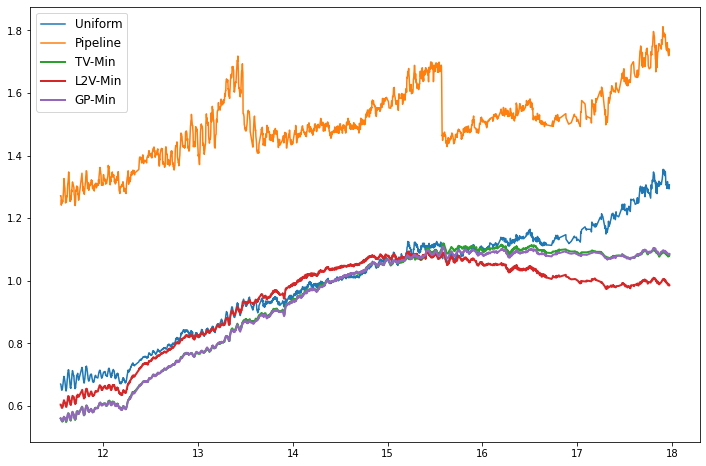

In [18]:
fig = plt.figure(figsize=(12.0,8.0))

plt.plot(wavels,uniform,label='Uniform')
plt.plot(wavels,ext_spec+0.5,label='Pipeline')


plt.plot(wavels,tv_final,label='TV-Min',lw=2)
plt.plot(wavels,l2v_final,label='L2V-Min',lw=2)
plt.plot(wavels,gp_final,label='GP-Min',lw=2)

# plt.plot(wavels,owl_final,label='OWL',lw=2)


plt.legend(fontsize=12)

So the optimized spectra don't look a lot better than with uniform weights, and none of them closely resemble the pipeline spectrum (which may be a feature, not a bug!).

## Visualize the Weight map

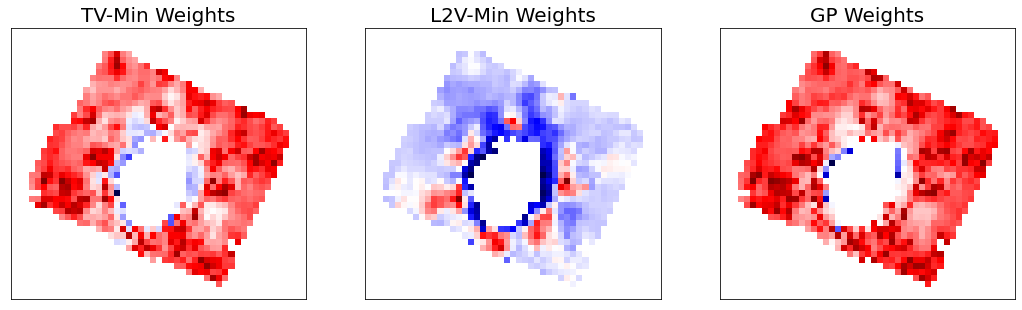

In [20]:
fig, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(18,6))

weightmap = onp.nan*goodpix
weightmap[goodpix] = obj.softmax(tv_params)
ax1.imshow(np.log10(weightmap),cmap=plt.cm.seismic)
ax1.set_title('TV-Min Weights',fontsize=20)

weightmap = onp.nan*goodpix
weightmap[goodpix] = obj.softmax(l2v_params)
ax2.imshow(np.log10(weightmap),cmap=plt.cm.seismic)
ax2.set_title('L2V-Min Weights',fontsize=20)

weightmap = onp.nan*goodpix
weightmap[goodpix] = obj.softmax(gp_params)
ax3.imshow(np.log10(weightmap),cmap=plt.cm.seismic)
ax3.set_title('GP Weights',fontsize=20)

for ax in (ax1,ax2,ax3):
    ax.set_xticks([])
    ax.set_yticks([])

Of the three, it looks like L2V (maximum smoothness) has picked out the PSF features nicely, whereas the others have mainly modelled the background.